In [22]:
import pandas as pd
data = pd.read_csv("Data_MLB_2025_StatcastPostseason_PitchByPitch_20251102a.csv")

In [ ]:
# need features that are available before or during the pitch - or else data leakage. not really sure which ones to use exactly
columns_to_drop = [
    'game_year', 'game_date', 'player_name', 'pitcher', 'batter', 
    'events', 'description', 'des','game_pk',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated',
    'zone', 'game_type', 'home_team', 'away_team', 'hit_location', 'bb_type',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
    'outs_when_up', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
    'fielder_2', 'fielder_2.1', 'fielder_2.2', 'fielder_2.3', 'fielder_3',
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
    'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value',
    'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',  'post_away_score', 'post_home_score'
    'post_bat_score', 'post_fld_score', 
]


data = data.drop(columns=columns_to_drop)

print(data.columns)


Remaining columns for modeling:
Index(['balls', 'strikes', 'inning', 'inning_topbot', 'at_bat_number',
       'pitch_number', 'pitch_type', 'pitch_name', 'release_speed',
       'release_pos_x', 'release_pos_z', 'spin_dir', 'stand', 'p_throws',
       'type', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk',
       'release_pos_y', 'home_score', 'away_score', 'bat_score', 'fld_score',
       'if_fielding_alignment', 'of_fielding_alignment', 'spin_axis',
       'delta_home_win_exp', 'delta_run_exp', 'bat_speed', 'swing_length'],
      dtype='object')


KeyboardInterrupt: 

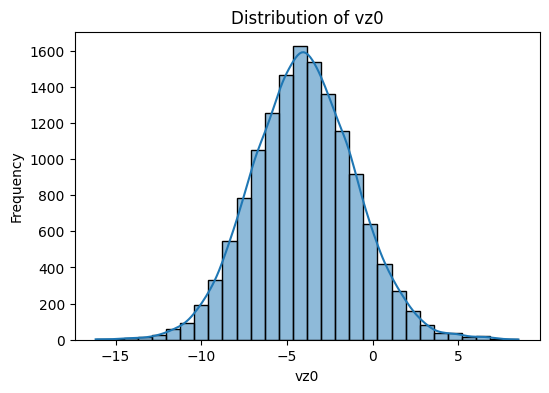

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("feature_visualizations", exist_ok=True)

# this isnt updated bc i dont know what features to do
# Separate numeric and categorical features
numeric_features = [
    'release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate',
    'release_extension', 'release_pos_y', 'spin_axis', 'delta_home_win_exp',
    'delta_run_exp', 'bat_speed', 'swing_length'
]

categorical_features = ['stand', 'p_throws', 'type']  # type is the target

# Numeric Features: Histograms
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f"feature_visualizations/{col}_hist.png")
    plt.close()

# Categorical Features: Countplots
for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=data)
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(f"feature_visualizations/{col}_count.png")
    plt.close()

# Correlation Heatmap for numeric features 
plt.figure(figsize=(12,10))
corr = data[numeric_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.savefig("feature_visualizations/correlation_heatmap.png")
plt.close()
